# **2022-ice_discharge** - Calculate Grounded Ice Flux

This notebook provides a general workflow to estimate grounded ice fluxes for [any] mapped ice boundaries in Antarctica. The following datasets are used *(as of Version -1.0)*:
* MEaSUREs BedMachine Bed Topography
* MEaSUREs Grounding Line
* MEaSUREs Ice Boundaries
* ATL14 Gridded Land Ice Height
* ATL15 Gridded Land Ice Height Change
* ITS_LIVE Ice Velocity (2018)

## Contributors

* Mark Hehlen
* Bryony Freer
* Emily Glazer
* Hui Gao
* Julia Andreasen
* Lizzie Hebel
* Lawrence Bird

## General workflow

The general approach for this work is as follows:
1. Define an area-of-interest (ice boundary)
2. Ingest key datasets from NSIDC
3. Crop Antarctica-wide datasets to given area-of-interest

4. 
- Download ATL14 (specific resolution)
- Download ATL15 (specific resolution)
- Can we do this for a line? if so, just download the data for the given flux gate (use grounding line to start with)
- Ingest ATL14 & AT15 data
- Crop ATl14 & ATL15 data for the aoi
- Calculate ATL14 + ATL15 DEMs (12 total)

5.
- Download velocity data (ITS_LIVE / MEaSUREs)
- Ingest velocity data
- Crop velocity data for the aoi

6. Align all raster data into A) consistent CRS and B) consistent grid.

7. Calculate ice thickness as the difference between ICESat-2 DEM and MEaSUREs bed topography DEM

8. Define a "flux-gate" based on mapped grounding line locations. Grounding lines are moved "upstream" X km to remove influence from floating ice
9. Calculate the flux across the flux-gate at a given time (t)
10. Plot a timeseries of the ice flux

### Future Expansion

Potential expansion of the current workflow includes:
* Use ATL06 along-track data to compute velocities at higher temporal resolution than available in gridded products (e.g., ITS_LIVE).
* Consider expanding velocity estimates to account for basal/shear stresses etc.
* Better define flux gates by shifting the grounding line upstream (based on flow directions) to remove effects of floating data.
 


# Step 0 - Dependancies & Authentication

In [14]:
# Import dependancies

import icepyx as ipx
from earthdata import Auth, DataCollections, DataGranules, Store # Used to ingest data from NSIDC
import geopandas as gpd # Used to subset regions using shapefile
import rioxarray as rx # Used to read raster data from hdf5 files
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
#%matplotlib widget 

In [15]:
# Authenticate Earthdata credentials

auth = Auth().login(strategy='netrc')
if auth.authenticated is False:
    auth = Auth().login(strategy='interactive')
    
earthdata_uid = 'lawrenceabird'
email = 'lawrence.bird@monash.edu'

You're now authenticated with NASA Earthdata Login


# Step 1 - Define static variables & Required processing steps

In [16]:
# Set a location to store datasets
data_loc = "/home/jovyan/shared/ice-discharge-data/"

# Define collection IDs for all NSIDC datasets that are required
bedmachine_collection = 'C1664160168-NSIDC_ECS' # MEaSUREs BedMachine dataset
boundaries_collection = 'C1454773262-NSIDC_ECS' # MEaSUREs Boundaries dataset
velocity_collection = 'C1414573008-NSIDC_ECS' # MEaSUREs Velocity dataset

# Define the ice boundary/basin of interest
basin = "Totten"


In [17]:
# What processing steps are required?
download_nsidc = False
download_atl = False
download_itslive = False

# Step 2 - Download (if required) key datasets

## Download NSIDC Datasets

In [6]:
# Download the NSIDC data (if required) - This only needs to be completed once as these datasets are Antarctic-wide.
if download_nsidc == True:
    access = Store(auth)
    
    # --- MEaSUREs BedMachine ---
    bedmachine_query = DataGranules(auth).concept_id(bedmachine_collection)
    bedmachine_granules = bedmachine_query.get()
    bedmachine_files = access.get(bedmachine_granules, local_path = data_loc)
    
    # --- MEaSUREs Velocity ---
    # velocity_query = DataGranules(auth).concept_id(velocity_collection)
    # velocity_granules = velocity_query.get()
    # velocity_files = access.get(velocity_granules, local_path = data_loc)
    
    # --- MEaSUREs Boundaries ---
    boundaries_query = DataGranules(auth).concept_id(boundaries_collection)
    boundaries_granules = boundaries_query.get()
    
    # TEMP: The following code section is a temporary fix to grab all files for multi-file granules. This is fixed in an udpated version of earhtdata.
    # Create a list of links to individual data files from each granule
    data_links = [granule.data_links() for granule in boundaries_granules]

    # Loop over the list of data links for each granule - for each file, wget the file.
    for i in data_links:
        tmp = i
        for j in tmp:
            #print(j)
            ! wget -nc {j} -P {data_loc+"/boundaries"}

## Download ITS_LIVE Velocity Dataset

In [7]:
# Download ITS_LIVE Annual velocity dataset - This only needs to be completed one as these datasets are Antarctic-wide.
if download_itslive == True:
    # Resolution=input("Enter the desired velocity resolution (120 or 240): ")
    # MosaicYear=input("Enter the desired year for its-live velocity mosaic (most recent 2018): ")

    Resolution = "240"
    MosaicYear = "2018"

    url = "https://its-live-data.s3.amazonaws.com/velocity_mosaic/landsat/v00.0/annual/ANT_G0"+Resolution+"_"+MosaicYear+".nc"

    ! wget -nc {url} -P {data_loc+"itslive"}

## Download ATL14 and ATL15 Datasets

In [8]:
if download_atl == True:
    
    # Ingest the boundaries to use as spatial extent for downloading ATL data
    boundaries = gpd.read_file(data_loc+"/boundaries/IceBoundaries_Antarctica_v02.shp")# Ice Boundaries shapefile
    
    # Select single basin to extract bounds (doesnt matter which one) 
    aoi = boundaries[(boundaries["NAME"] == basin) & (boundaries["TYPE"] == "GR")]

    # Rproject to EPSG 4326 (needed for icepyx)  
    def reproject(geom, epsg="EPSG:4326"):
        '''Function to reproject GPD polygon (default EPSG=4326)'''
        return geom.to_crs(epsg)
    
    # Reproject the aoi
    aoi_proj = reproject(aoi)

    # Extract bounding box coordinates and set to spatial extent for icepyx query 
    spatial_extent = list(aoi_proj.total_bounds)

In [9]:
if download_atl == True:

    #Set inputs to Icepyx download query 
    atl_15_name = 'ATL15'    
   
    # Make ipx Queries
    atl_15 = ipx.Query(atl_15_name, spatial_extent)
    # atl_15.visualize_spatial_extent()    

    # Authenticate EarthData Login
    atl_15.earthdata_login(earthdata_uid, email)
    
    # Order granules
    atl_15.order_granules()
    
    # Download to data_loc
    atl_15.download_granules(data_loc+"atl15/") 
    

In [ ]:
if download_atl == True:
    
    #Set inputs to Icepyx download query 
    atl_14_name = "ATL14"
    
    # Make ipx Queries
    atl_14 = ipx.Query(atl_14_name, spatial_extent)
    # atl14_.visualize_spatial_extent()
    
    # Authenticate EarthData Login
    atl_14.earthdata_login(earthdata_uid, email)
        
    # Order granules
    atl_14.order_granules()
    
    # Download to data_loc
    atl_14.download_granules(data_loc+"atl14/") 

# Step 3 - Crop NSIDC Datasets to area-of-interest

In [7]:
# Ingest required NSIDC datasets
boundaries = gpd.read_file(data_loc+"/boundaries/IceBoundaries_Antarctica_v02.shp")# Ice Boundaries shapefile
gl = gpd.read_file(data_loc+"/boundaries/GroundingLine_Antarctica_v02.shp")# Grounding line shapefile
bed = rx.open_rasterio(data_loc+"BedMachineAntarctica_2019-11-05_v01.nc", variable = "bed") # BedMachine 

BedMachineAntarctica CRS:  +init=epsg:3031
aoi shapefile CRS:  epsg:3031
gl shapefile CRS:  epsg:3031

Still using drainage basin outline.
Set buffer_distance to 0 if you are only interested in grounding line.
Or assign a positive number >= 500 to buffer_distance if you want to get an area upstream of grounding line.


<AxesSubplot:>

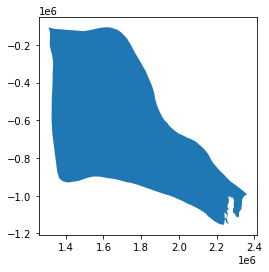

In [8]:
# Isolated boundary for only grounded ice (GR) for the chosen basin
aoi = boundaries[(boundaries["NAME"] == basin) & (boundaries["TYPE"] == "GR")]


"""
I moved the cell to here as we need to check the CRS before cropping
Feel free to merge or separate into different cells
"""
# Check the CRS of all NSIDC datasets
print(f"BedMachineAntarctica CRS: ", bed.attrs['proj4'])
print(f"aoi shapefile CRS: ", aoi.crs)
print(f"gl shapefile CRS: ", gl.crs)


#------------------------------------------------------------------------------------------------------------------------
## Change aoi from drainage basin to grounding line or an area upstream of grounding line within certain distance
gl_line = gl.geometry.boundary # Get grounding line linestring
gl_aoi = gpd.clip(gl_line, aoi) # Clip Grounding line to aoi

buffer_distance = -1 # meter, distance of buffer: set to 0 if only along the grounding line
"""
BedMachineAntarctica has a 500m resolution, only distance >= this value would create meaningful buffer area.
min_buffer_distance value can be adjusted according to different datasets
"""
min_buffer_distance = 500 
if buffer_distance == 0: # Only along the grounding line
    aoi = gl_aoi
elif buffer_distance >= min_buffer_distance: # use a buffer to crop an area upstream of grounding line
    aoi = gpd.clip(aoi, gl) # in case ice boundary is outside of GL: exclude potential area downstream of grounding line
    aoi = gpd.clip(aoi, gl_aoi.buffer(buffer_distance, cap_style=1, join_style=1))
else:
    print("\nStill using drainage basin outline.\nSet buffer_distance to 0 if you are only interested in grounding line.")
    print("Or assign a positive number >= "+str(min_buffer_distance)+" to buffer_distance if you want to get an area upstream of grounding line.")

aoi.plot()

In [9]:
'''
Clip raster using a shapefile
aoi: shapefile of interested region; ds: xarray dataset (bedmachine, atl14/15,...);
x_dim/y_dim: variable name of x and y dimensions in xarray dataset (typically is "x", "y")
'''
def clip_raster(aoi, ds, x_dim, y_dim):
    # Clip a xarray dataset Data to aoi
    ds.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    ds.rio.write_crs("EPSG:3031", inplace=True) # Write the CRS to the bed object so that it's consistent with other objects
    ds_aoi = ds.rio.clip(aoi.geometry, aoi.crs)
    return ds_aoi

CPU times: user 4.6 s, sys: 992 ms, total: 5.59 s
Wall time: 5.67 s


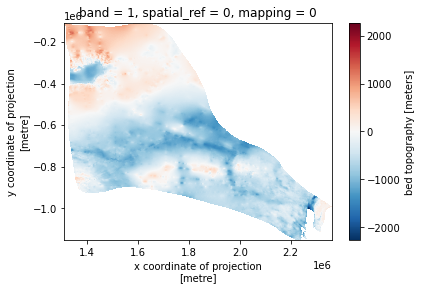

In [10]:
%%time
# Clip/Mask the NSIDC Raster product(s) to the aoi basin boundary

# Clip BedMachine Data to aoi
bed_aoi = clip_raster(aoi, bed, "x", "y")

# Mask BedMachine Data to aoi
bed_aoi_masked = bed_aoi.where(bed_aoi['bed'] != -9999.) # Replace -9999. with nan for display
bed_aoi_masked['bed'].plot()

In [11]:
%%time

# Crop ATL14 and ATL15 using aoi shapefile
atl_n = ["atl14", "atl15"]
for fdir in atl_n:
    if fdir == "atl14":
        atl_f = data_loc + fdir +"/ATL14_AA_0311_100m_001_01.nc"
        atl14 = xr.open_dataset(atl_f)
        atl_h = atl14[['h']]
        
        # Crop using the bounding box of aoi first
        aoi_bound_x = [aoi.total_bounds[0], aoi.total_bounds[2]]
        aoi_bound_y = [aoi.total_bounds[1], aoi.total_bounds[3]]
        atl_h = atl_h.rio.write_crs("EPSG:3031", inplace=True)
        atl_h = atl_h.rio.clip_box(
            minx=min(aoi_bound_x),
            miny=min(aoi_bound_y),
            maxx=max(aoi_bound_x),
            maxy=max(aoi_bound_y),
        )
        
        # Crop using the aoi shapefile
        atl_h_aoi = clip_raster(aoi, atl_h, "x", "y")
    elif fdir == "atl15":
        atl_f = data_loc + fdir +"/ATL15_AA_0311_01km_001_01.nc"
        atl15 = xr.open_dataset(atl_f, group="delta_h")
        atl_dh = atl15[['delta_h']]
        atl_dh_aoi = clip_raster(aoi, atl_dh, "x", "y")


CPU times: user 9.12 s, sys: 1.9 s, total: 11 s
Wall time: 12 s


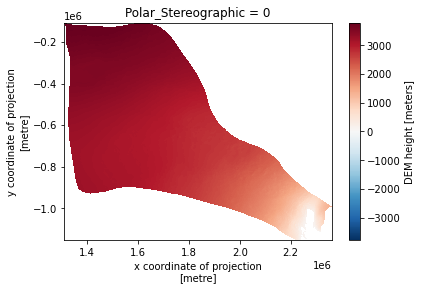

In [12]:
atl_h_aoi.h.plot()

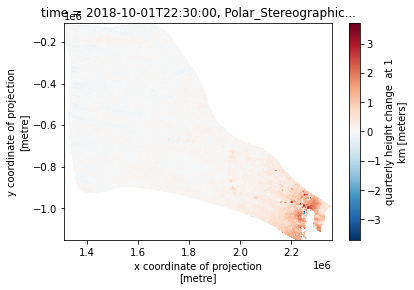

In [13]:
atl_dh_aoi.delta_h[0,:,:].plot()

# Step 4 - Calculate Seasonal DEMs from ATL Data